## Test MLDG by fitting the top and bottom halves of the image in a coordinated way

In [1]:
import time
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython import display
import moviepy.editor as mpy

from dataset import Dataset

Camera position mean & std:
[ -1.9723758  -11.407406     0.36299774] [10.950828   5.4356313 11.073948 ]


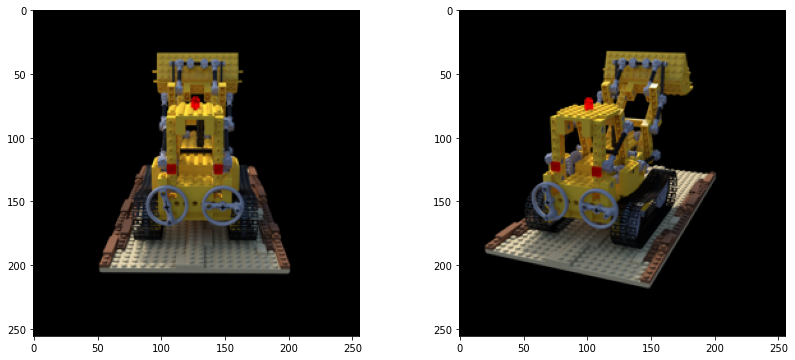

In [2]:
data = Dataset('../public/data/lego', 'blender')
H, W = data.H, data.W

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.imshow(data.images[0].permute(1,2,0))
plt.subplot(122)
plt.imshow(data.images[1].permute(1,2,0))
plt.show()

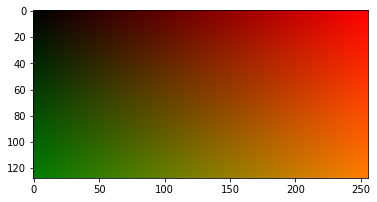

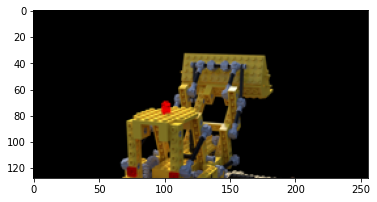

In [3]:
y = data.images[1:2].permute(0, 2, 3, 1).reshape(-1, 3).cuda()

i, j = torch.meshgrid(torch.arange(W), torch.arange(H), indexing='xy')
x = torch.stack([i / W, j / H, torch.zeros_like(i)], dim=-1)
x = x.reshape(-1, 3).cuda()

plt.imshow(x[:H*W//2].reshape(H//2, W, 3).cpu())
plt.show()
plt.imshow(y[:H*W//2].reshape(H//2, W, 3).cpu())
plt.show()

In [4]:
# https://davidlindell.com/publications/bacon

class Bacon(nn.Module):
    def __init__(self, res=256, n_layers=4, n_feats=256):
        super().__init__()
        
        if (n_layers < 2):
            n_layers = 2
            print("min layers: 2")
        
        self.res = res
        self.n_layers = n_layers
        self.n_feats = n_feats
        
        # omega/phi
        # using tensors for gw instead of parameters with no grad (for mldg implementation)
        gw = [torch.empty(3, n_feats, device='cuda') \
                 for _ in range(n_layers + 1)]
        gb = nn.ParameterList([nn.Parameter(torch.rand(n_feats, requires_grad=True))
                               for _ in range(n_layers + 1)])
        
        zwb = [nn.Linear(n_feats, n_feats) \
              for _ in range(n_layers)]
        ywb = [nn.Linear(n_feats, 3) \
               for _ in range(n_layers)]
        
        # max bandwidth
        total_B = np.pi * res
        # first 2 tb/8, rest set to sum to tb
        B = [total_B / 8] * 2
        B += [total_B * 3 / 4 / (n_layers - 1)] * (n_layers - 1)
        
        nn.init.uniform_(gw[0], -B[0], B[0])
        nn.init.uniform_(gb[0], -np.pi, np.pi)
        for i, (lgw, lgb, lz, ly) in enumerate(zip(gw[1:], gb[1:], zwb, ywb)):
            nn.init.uniform_(lgw, -B[i + 1], B[i + 1])
            nn.init.uniform_(lgb, -np.pi, np.pi)
            nn.init.uniform_(lz.weight, -np.sqrt(6/n_feats),
                             np.sqrt(6/n_feats))
        
        self.gw = gw
        self.gb = gb
        self.zwb = nn.ModuleList(zwb)
        self.ywb = nn.ModuleList(ywb)
    
    def forward(self, x):
        x = x.clone()
        x[:, -1] /= self.res / 4
        y = []
        g = torch.sin(x @ self.gw[0] + self.gb[0])
        for i in range(self.n_layers):
            z = torch.sin(x @ self.gw[i + 1] + self.gb[i + 1])
            z = g * self.zwb[i](z)
            y.append(self.ywb[i](z))
        
        return y

mse = nn.MSELoss()
def loss_fn(output, target):
    return sum([mse(v, target) for v in output]) / len(output)

In [5]:
# https://arxiv.org/pdf/1710.03463.pdf - Learning to Generalize: Meta-Learning for Domain Generalization
# https://github.com/facebookresearch/DomainBed/blob/main/domainbed/algorithms.py#L477

from itertools import cycle
import copy
import torch.nn.functional as F
from torch import autograd
import higher

class Algorithm(torch.nn.Module):
    """
    A subclass of Algorithm implements a domain generalization algorithm.
    Subclasses should implement the following:
    - update()
    - predict()
    """
    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(Algorithm, self).__init__()
        self.hparams = hparams

    def update(self, minibatches, unlabeled=None):
        """
        Perform one update step, given a list of (x, y) tuples for all
        environments.
        Admits an optional list of unlabeled minibatches from the test domains,
        when task is domain_adaptation.
        """
        raise NotImplementedError

    def predict(self, x):
        raise NotImplementedError

class ERM(Algorithm):
    """
    Empirical Risk Minimization (ERM)
    """

    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(ERM, self).__init__(input_shape, num_classes, num_domains,
                                  hparams)
        """
        self.featurizer = networks.Featurizer(input_shape, self.hparams)
        self.classifier = networks.Classifier(
            self.featurizer.n_outputs,
            num_classes,
            self.hparams['nonlinear_classifier'])

        self.network = nn.Sequential(self.featurizer, self.classifier)
        """
        self.network = Bacon()
        self.optimizer = torch.optim.Adam(
            self.network.parameters(),
            lr=self.hparams["lr"],
            weight_decay=self.hparams['weight_decay']
        )

    def update(self, minibatches, unlabeled=None):
        all_x = torch.cat([x for x,y in minibatches])
        all_y = torch.cat([y for x,y in minibatches])
        loss = F.cross_entropy(self.predict(all_x), all_y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return {'loss': loss.item()}

    def predict(self, x):
        return self.network(x)



class MLDG(ERM):
    """
    Model-Agnostic Meta-Learning
    Algorithm 1 / Equation (3) from: https://arxiv.org/pdf/1710.03463.pdf
    Related: https://arxiv.org/pdf/1703.03400.pdf
    Related: https://arxiv.org/pdf/1910.13580.pdf
    """
    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(MLDG, self).__init__(input_shape, num_classes, num_domains,
                                   hparams)
        self.num_meta_test = hparams['n_meta_test']
    
    # minibatches format is different here
    def update(self, minibatches, first_order=True):
        """
        Terms being computed:
            * Li = Loss(xi, yi, params)
            * Gi = Grad(Li, params)
            * Lj = Loss(xj, yj, Optimizer(params, grad(Li, params)))
            * Gj = Grad(Lj, params)
            * params = Optimizer(params, Grad(Li + beta * Lj, params))
            *        = Optimizer(params, Gi + beta * Gj)
        That is, when calling .step(), we want grads to be Gi + beta * Gj
        For computational efficiency, we do not compute second derivatives.
        """
        if first_order:
            num_mb = len(minibatches) # 2
            objective = 0

            self.optimizer.zero_grad()
            for p in self.network.parameters():
                if p.grad is None:
                    p.grad = torch.zeros_like(p)

            ## single task
            [(xi, yi), (xj, yj)] = minibatches

            # fine tune clone-network on task "i"
            inner_net = copy.deepcopy(self.network)

            inner_opt = torch.optim.Adam(
                inner_net.parameters(),
                lr=self.hparams['lr'],
                weight_decay=self.hparams['weight_decay']
            )

            # changed from cross_entropy
            inner_obj = loss_fn(inner_net(xi), yi)

            inner_opt.zero_grad()
            inner_obj.backward()
            inner_opt.step()

            # The network has now accumulated gradients Gi
            # The clone-network has now parameters P - lr * Gi
            for p_tgt, p_src in zip(self.network.parameters(),
                                    inner_net.parameters()):
                if p_src.grad is not None:
                    p_tgt.grad.data.add_(p_src.grad.data / num_mb)

            # `objective` is populated for reporting purposes
            objective += inner_obj.item()

            # this computes Gj on the clone-network
            loss_inner_j = loss_fn(inner_net(xj), yj)
            grad_inner_j = autograd.grad(loss_inner_j, inner_net.parameters(),
                allow_unused=True)

            # `objective` is populated for reporting purposes
            objective += (self.hparams['mldg_beta'] * loss_inner_j).item()

            for p, g_j in zip(self.network.parameters(), grad_inner_j):
                if g_j is not None:
                    p.grad.data.add_(
                        self.hparams['mldg_beta'] * g_j.data / num_mb)

            # The network has now accumulated gradients Gi + beta * Gj
            # Repeat for all train-test splits, do .step()

            ## end single task

            objective /= num_mb

            self.optimizer.step()

            return {'loss': objective}
        
        else:
            # This commented "update" method back-propagates through the gradients of
            # the inner update, as suggested in the original MAML paper.  However, this
            # is twice as expensive as the uncommented "update" method, which does not
            # compute second-order derivatives, implementing the First-Order MAML
            # method (FOMAML) described in the original MAML paper.
            objective = 0
            beta = self.hparams['mldg_beta']
            #inner_iterations = self.hparams['inner_iterations']
            inner_iterations = 1

            self.optimizer.zero_grad()

            with higher.innerloop_ctx(self.network, self.optimizer,
                copy_initial_weights=False) as (inner_network, inner_optimizer):

                ## single task
                [(xi, yi), (xj, yj)] = minibatches
                for inner_iteration in range(inner_iterations):
                    li = loss_fn(inner_network(xi), yi)
                    inner_optimizer.step(li)

                objective += loss_fn(self.network(xi), yi)
                objective += beta * loss_fn(inner_network(xj), yj)
                # end single task

                objective /= len(minibatches)
                objective.backward()

            self.optimizer.step()

            return {'loss': objective.item()}

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = int(2e4)
# lr is for both inner and outer (alpha and gamma)
model = MLDG(0, 0, 0, {
    'lr': 5e-4, 'weight_decay': 0., 'mldg_beta': 1.,
    'n_meta_test': batch_size // 2
})
model.to(device)

losses = np.array([])

2000/2000
56s - eta 0s


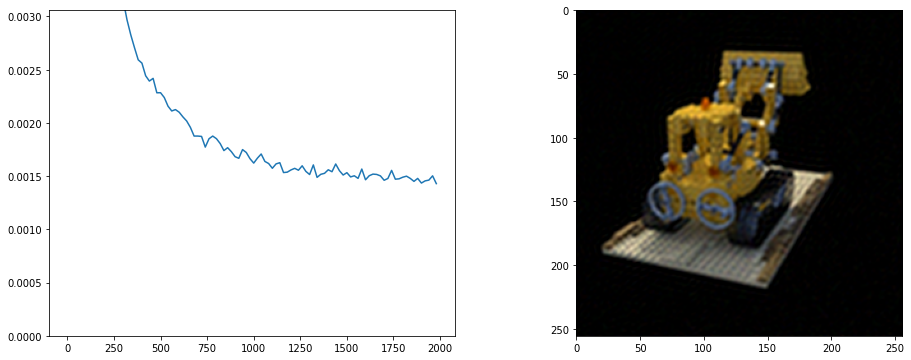

In [7]:
train_st = time.time()
time_to_s = lambda t: (f'{int(t / 60)}m' if t >= 60 else '') + f'{int(t) % 60}s'

n_iter = int(2e3)

for i in range(n_iter):
    sel_i = np.random.choice(x.shape[0] // 2, batch_size // 2)
    sel_j = x.shape[0] // 2 + np.random.choice(x.shape[0] // 2, batch_size // 2)
    minibatch = [(x[sel_i], y[sel_i]), (x[sel_j], y[sel_j])]
    step_vals = model.update(minibatch)
    
    if (i + 1) % 20 == 0:
        losses = np.append(losses, step_vals['loss'])
    if (i + 1) % 200 == 0:
        display.clear_output(wait=True)
        print(f'{i+1}/{n_iter}')
        time_passed = time.time() - train_st
        eta = time_passed * (n_iter - i) / i
        print(f'{time_to_s(time_passed)} - eta {time_to_s(eta)}')
        plt.figure(figsize=(16, 6))
        plt.subplot(121)
        plt.plot(np.arange(len(losses)) * 20, losses)
        plt.ylim([0, losses[-len(losses)//2:].mean() * 2])
        plt.subplot(122)
        with torch.no_grad():
            pred = model.predict(x[:H*W])[-1]
            plt.imshow(pred.clip(0,1).reshape(H, W, 3).cpu())
        plt.show()